<a href="https://colab.research.google.com/github/pachterlab/GRNP_2020/blob/master/notebooks/figure_generation/GenFig4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generates figure 4**

This notebook generates a figure that shows that two datasets created from the same biological sample, but with different technologies, become more similar when predicted, and less similar when downsampled. 

Steps:
1. Download the code and processed data
2. Setup the R environment
3. Generate the figure


**1. Download the code and processed data**

In [1]:
#download the R code
![ -d "GRNP_2020" ] && rm -r GRNP_2020

!git clone https://github.com/pachterlab/GRNP_2020.git


Cloning into 'GRNP_2020'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 1176 (delta 203), reused 83 (delta 47), pack-reused 883
Receiving objects: 100% (1176/1176), 7.54 MiB | 5.24 MiB/s, done.
Resolving deltas: 100% (757/757), done.


In [10]:
#download processed data from Zenodo for all datasets
![ -d "figureData" ] && rm -r figureData
!mkdir figureData
!cd figureData && wget https://zenodo.org/record/3909758/files/EVALPBMC.zip?download=1 && unzip 'EVALPBMC.zip?download=1' && rm 'EVALPBMC.zip?download=1'
!cd figureData && wget https://zenodo.org/record/3909758/files/EVALPBMC_DS.zip?download=1 && unzip 'EVALPBMC_DS.zip?download=1' && rm 'EVALPBMC_DS.zip?download=1'
!cd figureData && wget https://zenodo.org/record/3909758/files/FigureData.zip?download=1 && unzip 'FigureData.zip?download=1' && rm 'FigureData.zip?download=1'


--2020-07-02 23:33:25--  https://zenodo.org/record/3909758/files/EVALPBMC.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467646609 (446M) [application/octet-stream]
Saving to: ‘EVALPBMC.zip?download=1’

EVALPBMC.zip?downlo 100%[===================>] 445.98M  3.86MB/s    in 76s     

2020-07-02 23:34:43 (5.84 MB/s) - ‘EVALPBMC.zip?download=1’ saved [467646609/467646609]

Archive:  EVALPBMC.zip?download=1
   creating: EVALPBMC/
  inflating: EVALPBMC/Bug_10.RData   
  inflating: EVALPBMC/Bug_100.RData  
  inflating: EVALPBMC/Bug_20.RData   
  inflating: EVALPBMC/Bug_40.RData   
  inflating: EVALPBMC/Bug_5.RData    
  inflating: EVALPBMC/Bug_60.RData   
  inflating: EVALPBMC/Bug_80.RData   
  inflating: EVALPBMC/ds_summary.txt  
  inflating: EVALPBMC/pooledHist.RData  
  inflating: EVALPBMC/pooledHistDS.RData  
  inflating: EVALPBMC/PredEvalDa

In [3]:
#Check that download worked
!cd figureData && ls -l && cd EVALPBMC && ls -l

total 8
drwxr-xr-x 2 root root 4096 Jul  1 20:29 EVALPBMC
drwxr-xr-x 2 root root 4096 Jul  1 21:25 EVALPBMC_DS
total 486724
-rw-r--r-- 1 root root 87322865 Jun 30 12:01 Bug_100.RData
-rw-r--r-- 1 root root 53475778 Jun 30 11:52 Bug_10.RData
-rw-r--r-- 1 root root 65711410 Jun 30 11:53 Bug_20.RData
-rw-r--r-- 1 root root 75161084 Jun 30 11:56 Bug_40.RData
-rw-r--r-- 1 root root 37818341 Jun 30 11:52 Bug_5.RData
-rw-r--r-- 1 root root 80649419 Jun 30 11:58 Bug_60.RData
-rw-r--r-- 1 root root 84316810 Jun 30 12:00 Bug_80.RData
-rw-r--r-- 1 root root      992 Jul  1 02:30 ds_summary.txt
-rw-r--r-- 1 root root   316188 Jul  1 15:25 pooledHistDS.RData
-rw-r--r-- 1 root root   720120 Jul  1 15:25 pooledHist.RData
-rw-r--r-- 1 root root 11259902 Jul  1 20:29 PredEvalData.RDS
-rw-r--r-- 1 root root  1633732 Jun 30 12:01 Stats.RData


**2. Prepare the R environment**

In [4]:
#switch to R mode
%reload_ext rpy2.ipython


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
#install the R packages and setup paths
%%R
install.packages("dplyr")
install.packages("ggplot2")
install.packages("DescTools")
install.packages("ggpubr")



R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/dplyr_1.0.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 836651 bytes (817 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

**3. Generate the figure**


In [6]:
#First set some path variables
%%R
source("GRNP_2020/RCode/pathsGoogleColab.R")


In [7]:
#Import the code for prediction (available in other notebooks)
%%R
source(paste0(sourcePath,"ButterflyHelpers.R"))
#source(paste0(sourcePath,"preseqHelpers.R"))
source(paste0(sourcePath,"CCCHelpers.R"))





R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
#create figure directory
![ -d "figures" ] && rm -r figures
!mkdir figures

[1] "Number of genes: 1018"


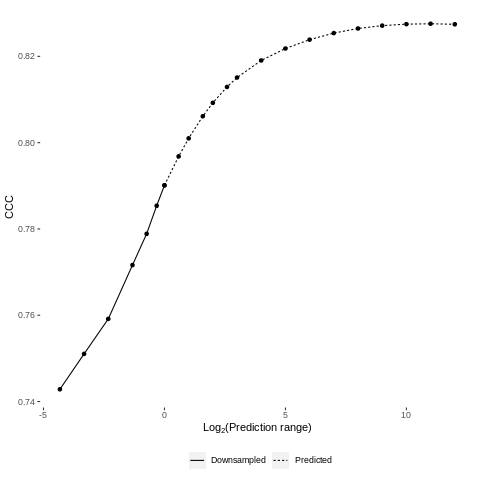

In [12]:
#Create and save the figure
%%R

library(ggplot2)
library(ggpubr)

#create a function for generating this type of plot (makes it easier to compare more datasets)
#assumes the stats are loaded
#expects the first in predVals to be 1
genFig4Plot <- function(dsid1, dsid2, predVals, cpmfiltLimit, title, precalcData) {
  stats1 = get(paste0("stats",dsid1), envir=.GlobalEnv)
  stats2 = get(paste0("stats",dsid2), envir=.GlobalEnv)

  pred1 = precalcData[[1]];
  pred2 = precalcData[[2]];
  
  
  merged = inner_join(pred1, pred2, by="gene")
  #CPM for filtering below
  for (i in 2:(2*length(predVals)+1)) {
    merged[,i] = merged[,i]*10^6/sum(merged[,i])
  }
  
  #extract down-sampled expression from stats:
  dsx = c(0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1)
  dsGrade = c(5,10,20,40,60,80,100)
  ids1 = NULL
  ids2 = NULL
  for (gr in dsGrade) {
    ids1 = c(ids1, paste0("CPM_", dsid1, "_d_", gr))
    ids2 = c(ids2, paste0("CPM_", dsid2, "_d_", gr))
  }
  ds1 = stats1[,c(1,which(colnames(stats1) %in% ids1))]
  ds2 = stats2[,c(1,which(colnames(stats2) %in% ids2))]
  mergedDs = inner_join(ds1, ds2, by="gene")
 
  #filter out the lowly expressed genes - prediction is too uncertain for those genes to show any interesting results
  filt = merged[(merged$p1.x > cpmfiltLimit) & (merged$p1.y > cpmfiltLimit),]

  #Now merge predicted and downsampled
  mergedTot = inner_join(filt, mergedDs, by="gene")
  
  print(paste0("Number of genes: ", dim(mergedTot)[1]))
  
  #now CPM again to remove the uncertainty in the lowly expressed genes
  for (i in 2:(dim(mergedTot)[2])) {
    mergedTot[,i] = log2(mergedTot[,i]*10^6/sum(mergedTot[,i]) + 1)
  }
  
  #now create the plot
  cors = rep(0,length(predVals))
  for (i in 1:(length(predVals))) {
    cors[i] = getCCC(mergedTot[,i+1, drop=T], mergedTot[,i+length(predVals)+1, drop=T])
  }
  
  
  dsLen = length(dsGrade)
  cors2 = rep(0,dsLen)
  dsOffs =  2*length(predVals)+1
  for (i in 1:dsLen) {
    cors2[i] = getCCC(mergedTot[,dsOffs + i, drop=T], mergedTot[,dsOffs + i + dsLen, drop=T])
  }
  
  pred = factor(c(rep(0,dsLen),rep(1, length(predVals))), c(0,1), c("Downsampled", "Predicted"))
  
  df = data.frame(x=c(log2(dsx), log2(predVals)), y=c(cors2,cors), pred = pred)

  
  fig = ggplot(df, aes(x=x, y=y, linetype= pred)) + 
    geom_line() + geom_point() +
    labs(y=bquote(R^2~"vs Identity"), x=expression(Log[2]*"(Prediction range)"), title = title) +
    theme(panel.background = element_rect("white", "white", 0, 0, "white"), legend.position= "none")
  
  figLegend = ggplot(df, aes(x=x, y=y, linetype= pred)) + 
    geom_line() + geom_point() +
    labs(y="CCC", x=expression(Log[2]*"(Prediction range)")) +
    theme(panel.background = element_rect("white", "white", 0, 0, "white"), legend.position= "bottom", 
          legend.direction = "horizontal", legend.title = element_blank())
  
  
  return(list(fig, figLegend))
}


predVals_1 = c(1, 1.5, 2, 3, 4, 6, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096)
title = "10x Chromium v2 vs Drop-Seq"

loadStats("EVALPBMC_DS")
loadStats("EVALPBMC")

#get precalculated data (generated using GenFig4)
d1 = readRDS(paste0(figure_data_path, "Fig4_d1.RDS"))

l1 = genFig4Plot("EVALPBMC_DS", "EVALPBMC", predVals_1, 100, "Drop-Seq vs Chromium v2", d1)

fig4 = l1[[2]]

print(fig4)

ggsave(
  paste0(figure_path, "Fig4.png"),
  plot = fig4, device = "png",
  width = 3, height = 3, dpi = 300)
